In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append(r'/home/ch23/ML-BEES_yk/ML-BEES-eval/eval_utilities')
from spatial_temporal_metrics import Metrics
import visualization
import pandas as pd
import seaborn as sns
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap


### make the .csv/pandas dataframe for the conditioning evaluation

In [3]:
# load the ecland data as ground truth (ref)

# select 2021/2022 from Global dataset for the evaluation
# start with ecland_i6aj_o400_2010_2022_6h_euro.zarr
ecland_eval = xr.open_zarr("/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr").sel(time=slice("2021", "2022"))  
# train_ds = xr.open_zarr("/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr")  # Europe subset

# load the ailand data as mod

ailand_eval = xr.open_zarr("/data/ch23/data_ch23/euro_xgb_train_2010_2019_val_2020_2020_diagnostic_v2.zarr").sel(time=slice("2021", "2022"))  

/data/conda/envs/ailand/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


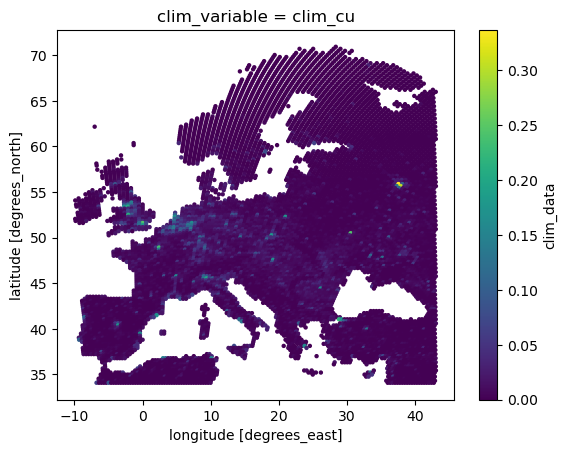

In [14]:
# visualize the spatial pattern of climate variables

ecland_eval.clim_data.sel(clim_variable="clim_cu").to_dataset().plot.scatter(x="lon", y="lat", hue="clim_data", s=10, edgecolors="none") # always convert to xarray dataset first
plt.show()

In [ ]:
eval_path_spatial="/home/ch23/data_ch23/evalution_results/euro_xgb_train_2010_2019_val_2020_2020_diagnostic_v2/spatial/"

In [15]:
# load the evaluation metrics file
eval_metrics_acc=xr.open_zarr(eval_path_spatial+"acc.zarr")
eval_metrics_bias=xr.open_zarr(eval_path_spatial+"bias.zarr")
eval_metrics_rmse=xr.open_zarr(eval_path_spatial+"rmse.zarr")
eval_metrics_nor_rmse=xr.open_zarr(eval_path_spatial+"nor_rmse.zarr")
eval_metrics_nor_bias=xr.open_zarr(eval_path_spatial+"nor_bias.zarr")
#eval_metrics_phaseshift=xr.open_zarr(eval_path+"spatialphase_shift.zarr")


FileNotFoundError: No such file or directory: '/home/ch23/data_ch23/evalution_results/xgbosst_train_2010_2019_val_2020_2020_est_50_hist/spatial/spatialphase_shift.zarr'

In [ ]:
# add climate variables from ecland to the dataframe for the conditioning analysis

data = {}
climate_var_metrics=pd.DataFrame(data)
for var in ecland_eval['clim_variable'].values:
    climate_var_metrics[var] = ecland_eval.clim_data.sel(clim_variable=var).values
# add lat/lon from ecland to the dataframe
climate_var_metrics['lat']=ecland_eval['lat'].values
climate_var_metrics['lon']=ecland_eval['lon'].values

In [ ]:
# combine and convert eval metrics, and ecland climate variables from .nc file to .csv 
# column index are the name of var or the name of the index
# for metrics result, var_name_metric_name
for var in eval_metrics_acc['variable'].values:
    climate_var_metrics['%s_acc' % var] = eval_metrics_acc.data.sel(variable=var).values

for var in eval_metrics_bias['variable'].values:
    climate_var_metrics['%s_bias' % var] = eval_metrics_bias.data.sel(variable=var).values

for var in eval_metrics_rmse['variable'].values:
    climate_var_metrics['%s_rmse' % var] = eval_metrics_rmse.data.sel(variable=var).values

for var in eval_metrics_nor_rmse['variable'].values:
    climate_var_metrics['%s_nor_rmse' % var] = eval_metrics_nor_rmse.data.sel(variable=var).values

for var in eval_metrics_nor_bias['variable'].values:
    climate_var_metrics['%s_nor_bias' % var] = eval_metrics_nor_bias.data.sel(variable=var).values

for var in eval_metrics_phaseshift['variable'].values:
    climate_var_metrics['%s_phaseshift' % var] = eval_metrics_phaseshift.data.sel(variable=var).values

In [ ]:
eval_path="/home/ch23/data_ch23/evalution_results/euro_xgb_train_2010_2019_val_2020_2020_diagnostic_v2/"

In [ ]:
# save the dataframe
climate_var_metrics.to_csv(eval_path+'climate_var_metrics.csv', index=False)

### load the saved dataframe

In [ ]:
climate_var_metrics=pd.read_csv(eval_path+'climate_var_metrics.csv')

In [ ]:
climate_var_metrics

,clim_cell_area,clim_landsea,clim_geopot,clim_cvl,clim_cvh,clim_tvl,clim_tvh,clim_sotype,clim_sdor,clim_sdfor,...,snowc_nor_bias,snowc_phaseshift,stl1_phaseshift,stl2_phaseshift,stl3_phaseshift,swvl1_phaseshift,swvl2_phaseshift,swvl3_phaseshift,clim_theta_pwp_value_range,lat_value_range
0,917961900.0,0.625206,963.5078,0.658287,0.083746,11.0,3.0,2.0,128.255370,76.488950,...,0.003133,140099954149248,140101229217632,140100021258112,140101162108784,140099819931504,140099819931504,140099954149248,0.14-0.17,67.26-70.94
1,918068500.0,0.513784,820.5078,0.677757,0.254194,2.0,3.0,2.0,90.886230,84.510864,...,0.110985,140099968686016,140101229217632,140100037002704,140101178262464,140099834883216,140099835935248,140099968686016,0.14-0.17,67.26-70.94
2,918068500.0,0.941957,1206.5078,0.759433,0.103141,11.0,5.0,1.0,155.935060,85.603390,...,0.050107,140099969414512,140101241646256,140100037568800,140101178262464,140099833562304,140099833562304,140099969414512,0.06-0.08,67.26-70.94
3,918068500.0,0.665172,1844.5078,0.670880,0.097921,11.0,3.0,1.0,149.462890,137.772770,...,0.184272,140099968686016,140101241646256,140100037002704,140101178262464,140099834883216,140099835935248,140099968686016,0.06-0.08,67.26-70.94
4,918068500.0,0.960058,1990.5078,0.621663,0.050742,11.0,3.0,1.0,133.923100,90.461060,...,0.110935,-4096,462438422842627243,94296099396648,0,140099833692212,7437527003338796405,-4096,0.06-0.08,67.26-70.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10046,819291200.0,0.999376,10494.5080,0.421449,0.000019,2.0,0.0,2.0,52.136475,27.822815,...,0.546130,0,140099835168656,140100021256480,140101162107008,17179869186,140101379780680,0,0.14-0.17,34.07-37.75
10047,819291200.0,1.000000,11571.5080,0.257325,0.000000,2.0,0.0,2.0,80.924805,26.452454,...,0.491736,1022202216448,80,30064771079,-14,-14,140101379951872,1022202216448,0.14-0.17,34.07-37.75
10048,819291200.0,1.000000,11582.5080,0.067173,0.000000,2.0,0.0,2.0,57.239990,5.820984,...,0.449952,0,641,34359738376,6,6,140101380289744,0,0.14-0.17,34.07-37.75
10049,819291200.0,1.000000,10778.5080,0.012592,0.000000,2.0,0.0,2.0,21.742676,4.633911,...,0.518894,94296188457936,140099832500704,25769803784,0,140100171810742,140101379951936,94296188457936,0.14-0.17,34.07-37.75


### Explanation of climate vairables
* `clim_cvl`, `clim_cvh` - low/high vegetation cover fraction of gridcell
* `clim_cu` - urban cover fraction
* `lat`, `lon` 
* `clim_glm` -- glacier cover

In [ ]:
# Identify the evaluation targets
# var1 is the climate variable -- Here shows the example for clim_cvl, low vegetation cover
var1='lat'
out_var='swvl1' # swvl1/2/3, stl1/2/3

/home/ch23/ML-BEES_yk/ML-BEES-eval/eval_utilities/visualization.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot=sns.boxplot(x='%s_percentile' % var1, y=var2, data=df,palette=colors)


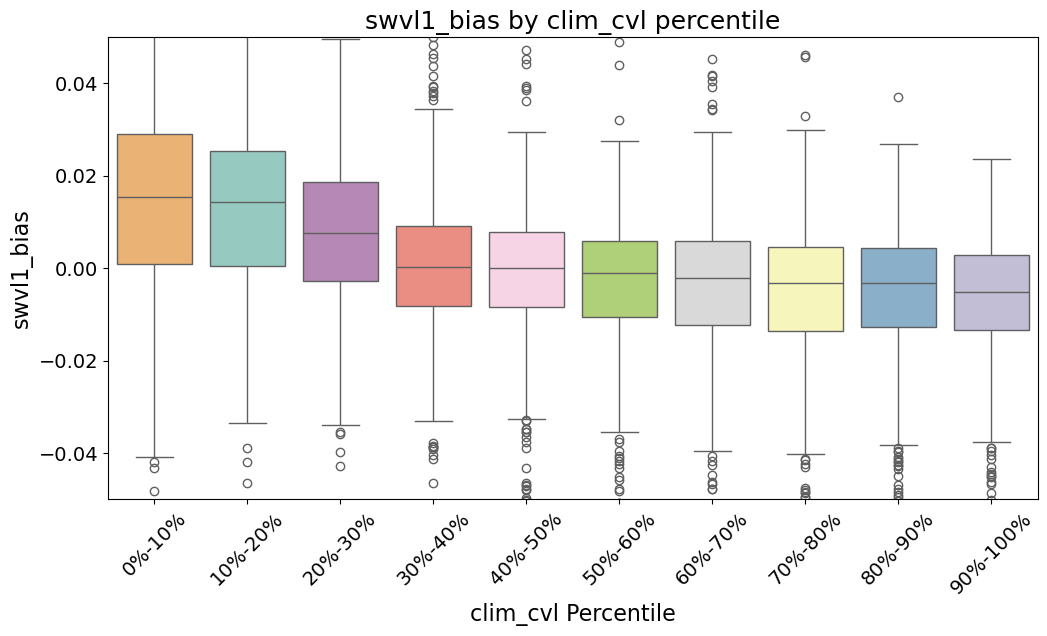

In [ ]:
# var2 is the metric 
var2='%s_bias' % out_var
ymin=-0.05 # set as None for a first guess
ymax=0.05
visualization.boxplot_percentile(climate_var_metrics, var1, var2, ymin, ymax)

/home/ch23/ML-BEES_yk/ML-BEES-eval/eval_utilities/visualization.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot=sns.boxplot(x='%s_percentile' % var1, y=var2, data=df,palette=colors)


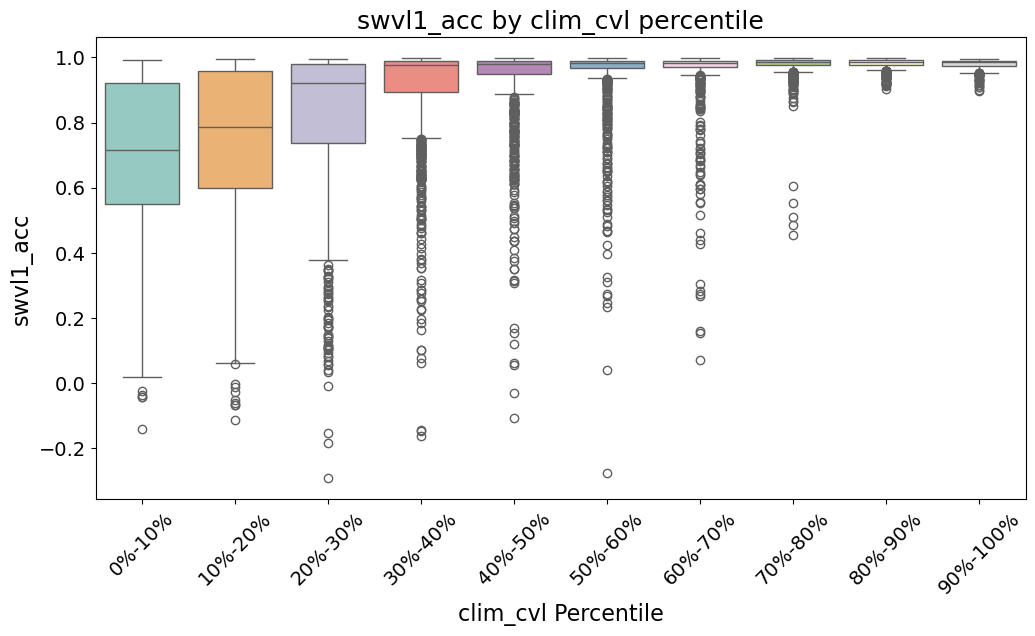

In [ ]:
# var2 is the metric
var2='%s_acc' % out_var
ymin=None # set as None for a first guess
ymax=None
visualization.boxplot_percentile(climate_var_metrics, var1, var2, ymin, ymax)

In [ ]:
# var2 is the metric
var2='swvl1_acc'
ymin=None # set as None for a first guess
ymax=None
visualization.boxplot_percentile(climate_var_metrics, var1, var2, ymin, ymax)

/home/ch23/ML-BEES_yk/ML-BEES-eval/eval_utilities/visualization.py:194: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot=sns.boxplot(x='%s_value_range' % var1, y=var2, data=df,palette=colors)


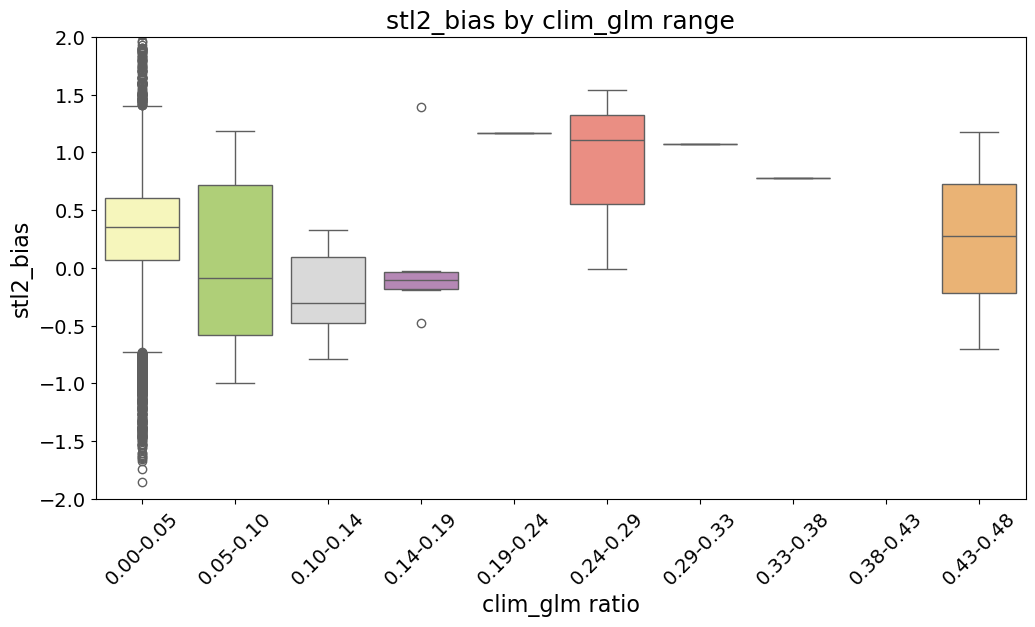

In [ ]:
# vavlue range plots
# var2 is the metric
var2='%s_bias' % out_var
ymin=-2 # set as None for a first guess
ymax=2
visualization.boxplot_value_range(climate_var_metrics, var1, var2, ymin, ymax)

/home/ch23/ML-BEES_yk/ML-BEES-eval/eval_utilities/visualization.py:194: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot=sns.boxplot(x='%s_value_range' % var1, y=var2, data=df,palette=colors)


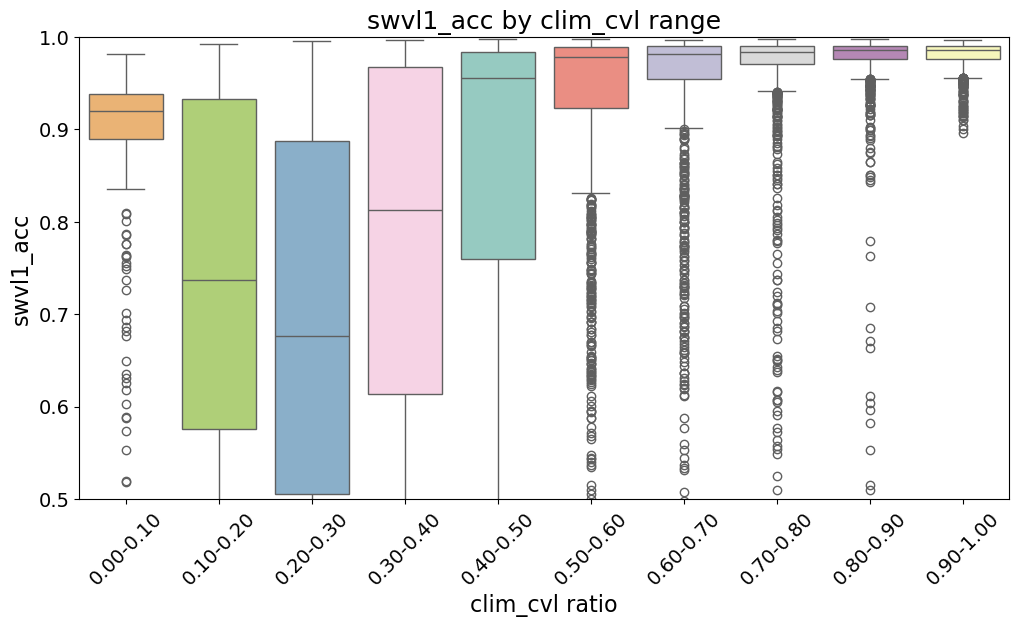

In [ ]:
# vavlue range plots
# var2 is the metric
var2='%s_acc' % out_var
ymin=0.5 # set as None for a first guess
ymax=1
visualization.boxplot_value_range(climate_var_metrics, var1, var2, ymin, ymax)

/home/ch23/ML-BEES_yk/ML-BEES-eval/eval_utilities/visualization.py:194: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot=sns.boxplot(x='%s_value_range' % var1, y=var2, data=df,palette=colors)


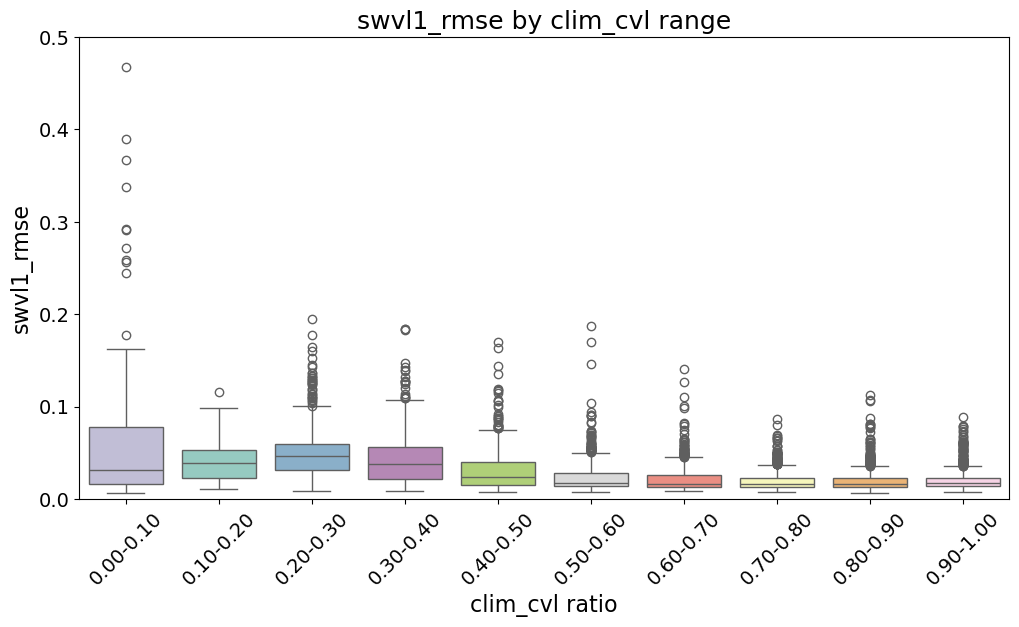

In [ ]:
# vavlue range plots
# var2 is the metric
var2='%s_rmse' % out_var
ymin=0 # set as None for a first guess
ymax=0.5
visualization.boxplot_value_range(climate_var_metrics, var1, var2, ymin, ymax)

/home/ch23/ML-BEES_yk/ML-BEES-eval/eval_utilities/visualization.py:194: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot=sns.boxplot(x='%s_value_range' % var1, y=var2, data=df,palette=colors)


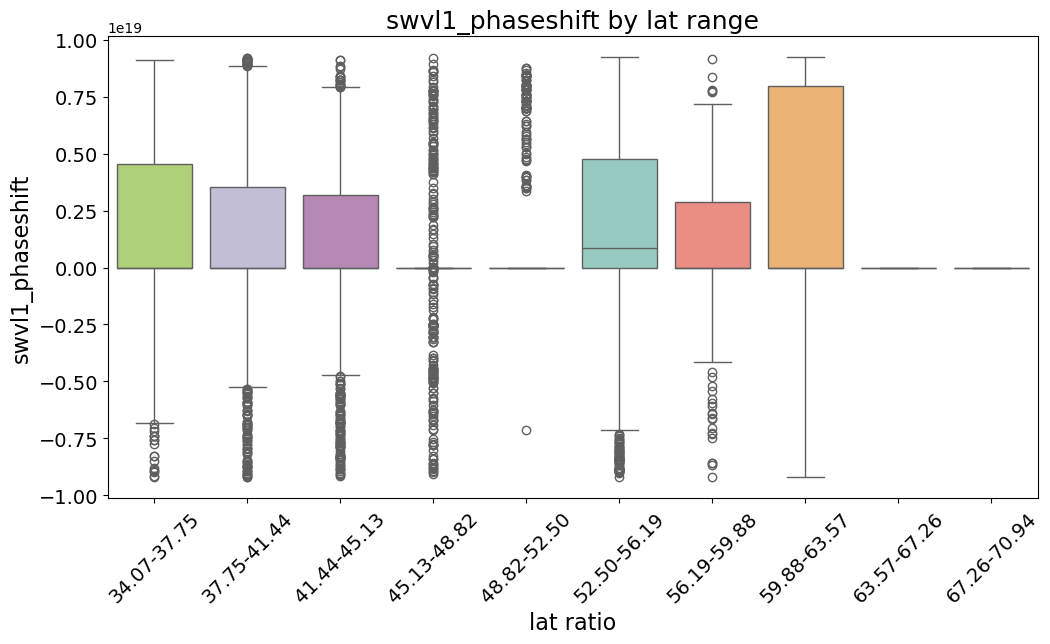

In [ ]:
# vavlue range plots
# var2 is the metric
var2='%s_phaseshift' % out_var
ymin=-0.5 # set as None for a first guess
ymax=None
visualization.boxplot_value_range(climate_var_metrics, var1, var2, ymin, ymax)

### boxplot by classes
* `clim_tvl`, `clim_tvh` - low/high vegetation type at gridcell
* `clim_sotype` - soil type
* `clim_veg_covl`, `clim_veg_covh` - average veg cover 
* `clim_theta_pwp` - partial wilting point of soil
* `clim_theta_cap` - field capacity of soil

/home/ch23/ML-BEES_yk/ML-BEES-eval/eval_utilities/visualization.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot=sns.boxplot(x=var1, y=var2, data=df,palette=colors)


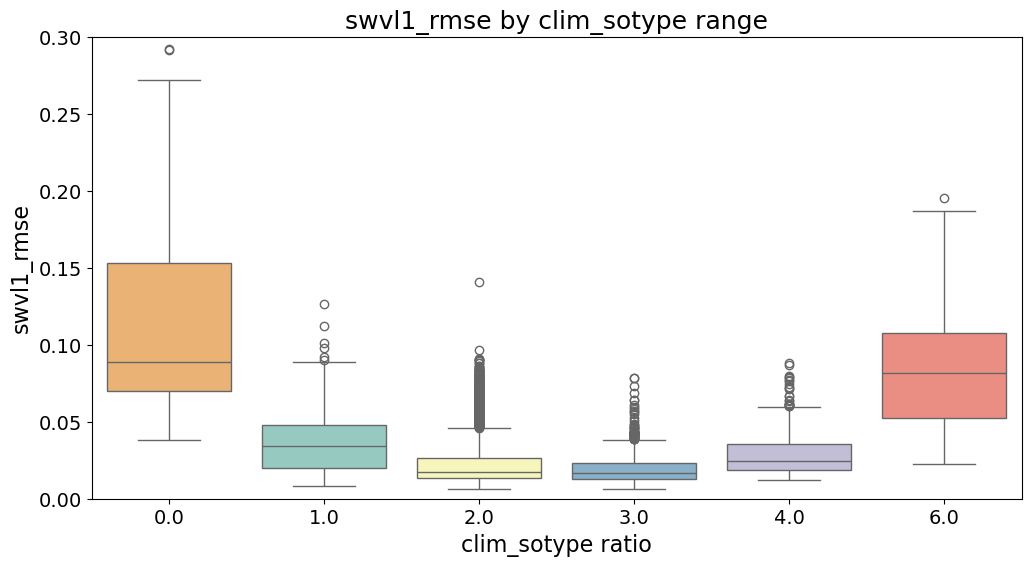

In [ ]:
out_var='swvl1' # swvl1/2/3, stl1/2/3
var1='clim_sotype' # here is an example for soil type
var2='%s_rmse' % out_var
ymin=0 # set as None for a first guess
ymax=0.3
visualization.boxplot_type(climate_var_metrics, var1, var2, ymin, ymax)

/home/ch23/ML-BEES_yk/ML-BEES-eval/eval_utilities/visualization.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot=sns.boxplot(x=var1, y=var2, data=df,palette=colors)


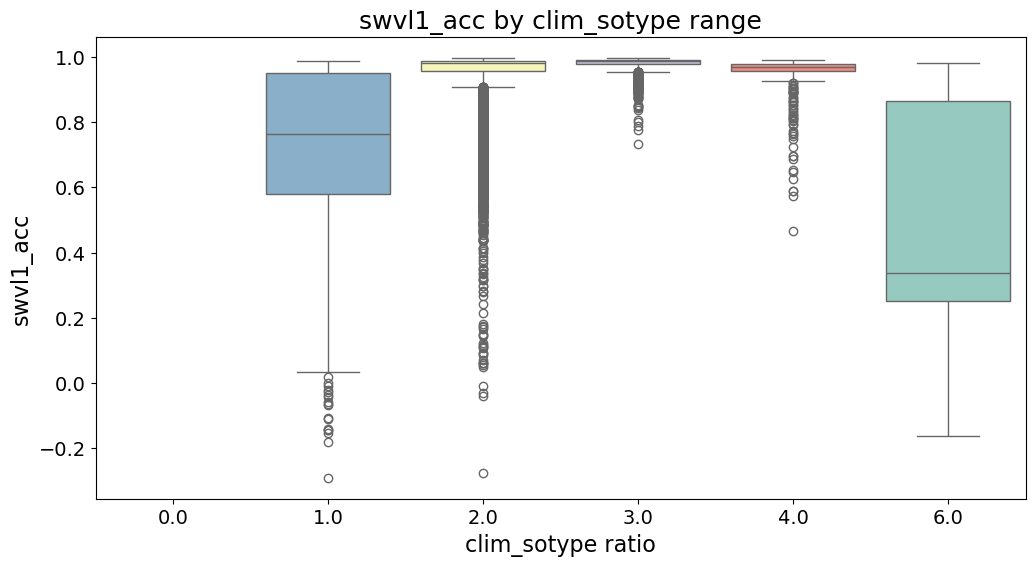

In [ ]:
var2='%s_acc' % out_var
ymin=None # set as None for a first guess
ymax=None
visualization.boxplot_type(climate_var_metrics, var1, var2, ymin, ymax)

/home/ch23/ML-BEES_yk/ML-BEES-eval/eval_utilities/visualization.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot=sns.boxplot(x=var1, y=var2, data=df,palette=colors)


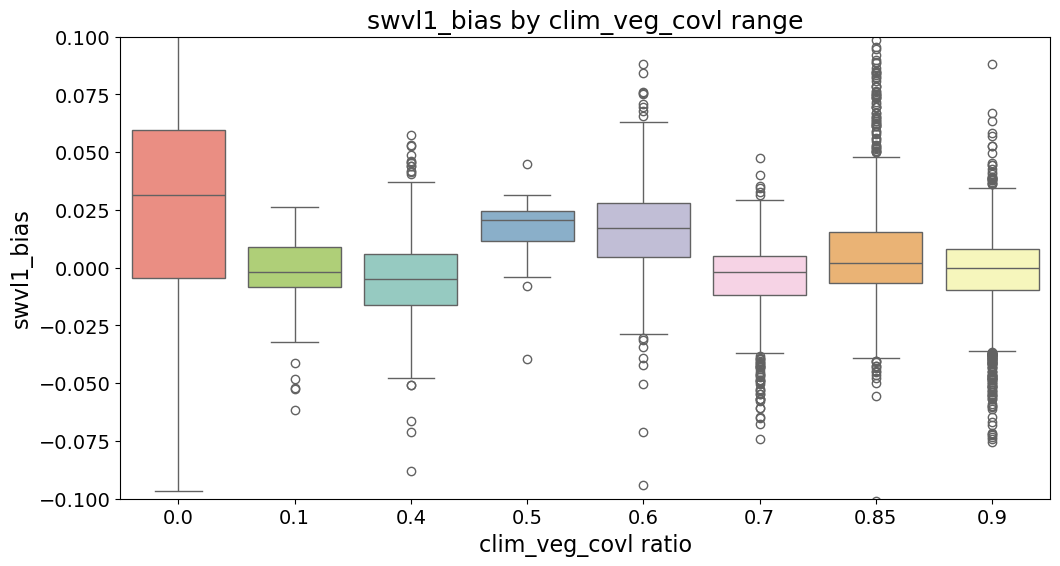

In [ ]:
var2='%s_bias' % out_var
ymin=-0.1 # set as None for a first guess
ymax=0.1
visualization.boxplot_type(climate_var_metrics, var1, var2, ymin, ymax)

In [ ]:
x = climate_var_metrics['clim_cvl']
y = climate_var_metrics['swvl1_bias']

### Density scatter plot

/data/conda/envs/ailand/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/data/conda/envs/ailand/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


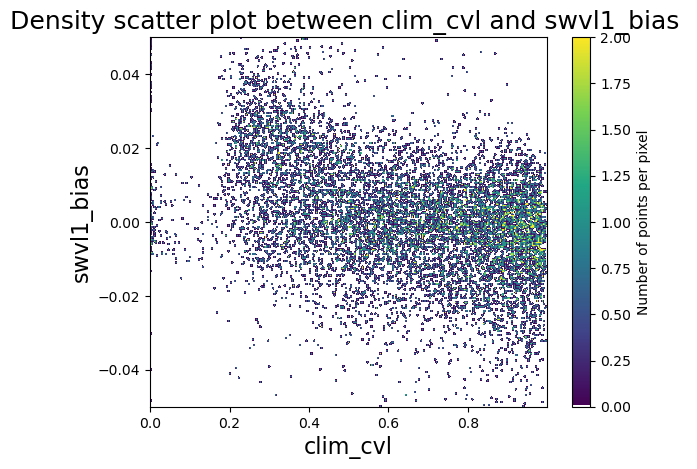

In [ ]:
var1='clim_cvl'
var2='swvl1_bias'
ymin=-0.05 # set as None for a first guess
ymax=0.05

visualization.density_scatter_plot(climate_var_metrics, var1, var2, ymin, ymax)

/data/conda/envs/ailand/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/data/conda/envs/ailand/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


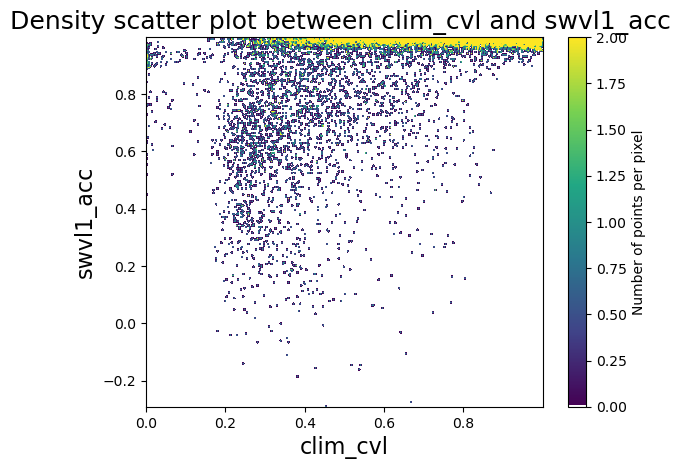

In [ ]:
var1='clim_cvl'
var2='swvl1_acc'
ymin=None # set as None for a first guess
ymax=None

visualization.density_scatter_plot(climate_var_metrics, var1, var2, ymin, ymax)

## spatial conditioning based on AR5 regions

### example to plot ACC based on AR5 regions

In [ ]:
from shapely.geometry import Point
import geopandas as gpd


# Open your shapefile and xarray object
eval_metrics_acc=xr.open_zarr("/home/ch23/data_ch23/evalution_results/xgbosst_train_2010_2019_val_2020_2020_est_50_hist/spatial/acc.zarr")
# load the AR5 shape file
gdf = gpd.read_file('/home/ch23/ML-BEES_yk/AR5_region_mask/referenceRegions.shp')  # replace with actual path or object

In [76]:
gdf # show the AR5 shape file

,NAME,LAB,USAGE,geometry
0,Alaska/N.W. Canada [ALA:1],ALA,land,"POLYGON ((-105.00000 60.00000, -168.00000 60.0..."
1,Amazon [AMZ:7],AMZ,land,"POLYGON ((-66.40000 -20.00000, -79.70000 -1.20..."
2,Central America/Mexico [CAM:6],CAM,land,"POLYGON ((-68.80000 11.40000, -79.70000 -1.200..."
3,small islands regions Caribbean,CAR*,all,"POLYGON ((-68.80000 11.40000, -85.80000 25.000..."
4,Central Asia [CAS:20],CAS,land,"POLYGON ((60.00000 30.00000, 60.00000 50.00000..."
5,Central Europe [CEU:12],CEU,land,"POLYGON ((-10.00000 45.00000, -10.00000 48.000..."
6,Canada/Greenland/Iceland [CGI:2],CGI,land,"POLYGON ((-10.00000 50.00000, -105.00000 50.00..."
7,Central North America [CNA:4],CNA,land,"POLYGON ((-85.00000 50.00000, -85.00000 28.600..."
8,East Africa [EAF:16],EAF,land,"POLYGON ((25.00000 -11.40000, 25.00000 15.0000..."
9,East Asia [EAS:22],EAS,land,"POLYGON ((100.00000 20.00000, 100.00000 50.000..."


5
11
15


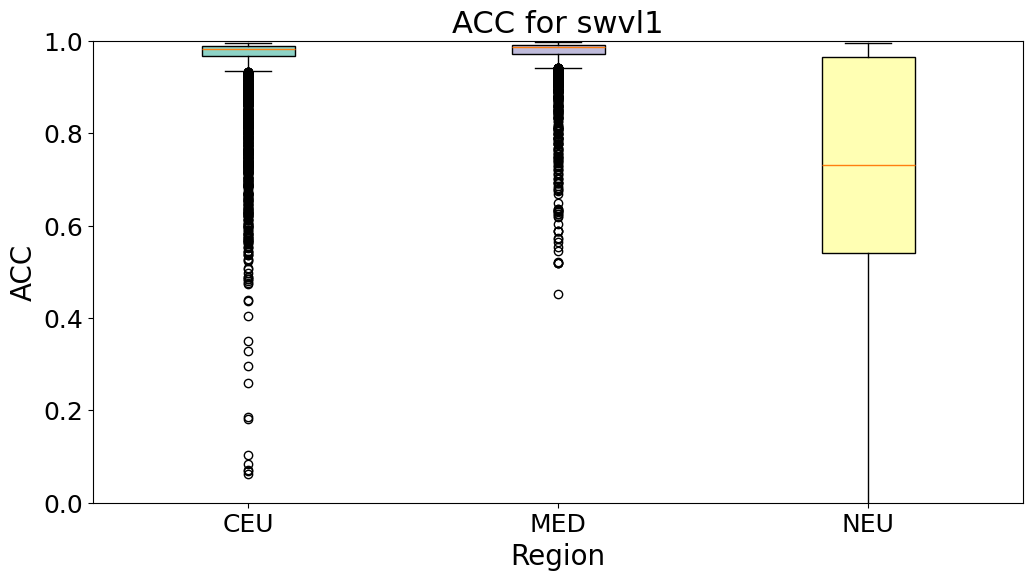

In [77]:
# load the parameters
# each time we can evaluate one metrics of one variable at all selected AR5 regions

error_zarr=eval_metrics_acc # the calculated error metrics
region_list=[5,11,15] # for EU domain, only 5 -- CEU, 11 -- MED, and 15 -- NEU
var1='swvl1'
var2='ACC'
ymin=0
ymax=1
boxplot_ar5(error_zarr, gdf, region_list, var1, var2, ymin, ymax)